In [1]:
print('__________________________')
print('')
print("Initialize Spectra Spectre")
print('__________________________')
import os, sys, json, time, fnmatch, glob, warnings, math, subprocess
from massql import msql_fileloading, msql_engine
import pandas as pd
from tqdm import tqdm
from pyteomics import mzxml, mzml
import numpy as np
from scipy.integrate import trapz
import scipy.signal
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
pd.options.mode.chained_assignment = None  # default='warn'

starting_directory = os.getcwd()
# pyinstaller command
# pyinstaller --noconfirm --noupx -F --console --collect-all "massql" --collect-all "matchms" --collect-all "pyarrow" --collect-all "pymzml" --exclude-module "kaleido"  "<absolute_path_to_script>"

# Convert jupyter notebok to script
# jupyter nbconvert --to script "<absolute_path_to_notebook>.ipynb"

__________________________

Initialize Spectra Spectre
__________________________


In [2]:
"""Do not run in Jupyter"""
# if getattr(sys, 'frozen', False):
#     bundle_dir = sys._MEIPASS
# else:
#     bundle_dir = os.path.dirname(os.path.abspath(__file__))

# if getattr(sys, 'frozen', False) and hasattr(sys, '_MEIPASS'):
#     print('Running in a PyInstaller bundle')
# else:
#     print('Running in a normal Python process')
# print('')
# print( 'bundle dir is', bundle_dir )
# print( 'sys.argv[0] is', sys.argv[0] )
# print( 'sys.executable is', sys.executable )
# print( 'os.getcwd is', os.getcwd() )
# print('__________________________')

'Do not run in Jupyter'

In [3]:
"""Configure"""
try:
    with open("spectre_config.json") as config_file:
        config = json.load(config_file)
        use_queryfile = config['use_queryfile']
        print("Use Query File Excel: "+str(use_queryfile))
        queryfile = config['queryfile']
        print("Query File Excel: "+str(queryfile))
        use_queryfilejson = config['use_queryfile_json']
        print("Use Query File JSON: "+str(use_queryfilejson))
        queryfilejson = config['queryfile_json']
        print("Query File JSON: "+str(queryfilejson))
        metadata_settings = config['metadata']
        print(metadata_settings)
        cache_setting = config['cache']
        print("Use Cache: "+str(cache_setting))
        datasaver = config['datasaver']
        print("Use Datasaver: "+str(datasaver))
        data_directory = config['data_directory']
        print("Data Directory: "+str(data_directory))
        QC_files = config['QC_files']
        kegg_path = config['kegg_path']
        convert_raw = config['convert_raw']
        print("Convert raw: "+str(convert_raw))
        msconvertexe = config['msconvert_exe']
        if convert_raw:
            print("MSConvert exe: "+str(msconvertexe))
except FileNotFoundError as e:
    print(f"FileNotFoundError\n"
          f"{e} \n"
          f"Not found in "+os.getcwd()+"\n")
    input("Press enter to exit...")
    exit()

Use Query File Excel: False
Query File Excel: MassQL_Queries.xlsx
Use Query File JSON: True
Query File JSON: MassQL_Queries_NIST.json
{'use_metadata': True, 'metadata_filename': 'Metadata.xlsx', 'filename_column': 'CORE_Filename', 'group_columns': ['USER_Column1']}
Use Cache: True
Use Datasaver: False
Data Directory: data/NISTSRM1950_Example_MassQLSmallMolecules/negative/
Convert raw: True
MSConvert exe: C:/Users/johnsondyj/AppData/Local/Apps/ProteoWizard 3.0.23118.b2ed96f 64-bit/msconvert.exe


In [4]:
"""Definition Used to Generate a Query from Excel"""
def create_query(name, KEGG, MS1_MZ, MS1_MZ_tolerance_ppm, rtmin, rtmax, group="A"):
    query = "QUERY scaninfo(MS1DATA) FILTER MS1MZ="+     str(MS1_MZ)+":TOLERANCEPPM="+     str(MS1_MZ_tolerance_ppm)+     " AND RTMIN="+(str(rtmin))+     " AND RTMAX="+str(rtmax)
    return {'name':name, 'KEGG': KEGG, 'group':group, 'query':query}

In [5]:
"""Create Queries from Query Files"""
queries_excel = []
query_groups = {}
name_kegg_dict = {}
MassQL_query_df = pd.DataFrame()
if use_queryfile and queryfile:
    try: 
        MassQL_query_df = pd.read_excel(queryfile)
        print("\nLoaded MassQL queries from: "+str(queryfile)+"\n")
        for index, row in MassQL_query_df.iterrows():
            if row['ion_mode'] == 1:
                MS1MZ = row['Monoisotopic'] + 1.00725
            else:
                MS1MZ = row['Monoisotopic'] - 1.00725
            queries_excel.append(create_query(row['Name'], row['KEGG'], row['Group'],  MS1MZ, row['TOLERANCEPPM'], row['RTMIN'], row['RTMAX']))
            name_kegg_dict.update({row['Name']: row['KEGG']})
            query_groups.update({row['Name']: row['Group']})
    except FileNotFoundError as e:
        print(f"FileNotFoundError\n"
              f"{e} \n"
              f"Not found in "+os.getcwd()+"\n")

queries_json = []
if use_queryfilejson:
    if queryfilejson:
        try:
            with open(queryfilejson) as queryfilej:
                queryjson = json.load(queryfilej)
                print("\nLoaded MassQL queries from: "+str(queryfilejson)+"\n")
                for entry in queryjson:
                    queries_json.append(entry)
                    name_kegg_dict.update({entry['name']: entry['KEGG']})
                    query_groups.update({entry['name']: entry['group']})
        except FileNotFoundError as e:
            print(f"FileNotFoundError\n"
                  f"{e} \n"
                  f"Not found in "+os.getcwd()+"\n")
        
queries = queries_excel + queries_json
if queries:
    print("\nCreated " + str(len(queries)) + " MassQL Queries")
else:
    print("No Queries Found")
    input("Press enter to exit...")
    exit()


Loaded MassQL queries from: MassQL_Queries_NIST.json


Created 6 MassQL Queries


In [6]:
"""Override MassQL definition to add datasaver function"""
def custom_load_data_mzML_pyteomics(input_filename, datasaver=datasaver):
    """
    This is a loading operation using pyteomics to help with loading mzML files with ion mobility
    Args:
        input_filename ([type]): [description]
    """

    previous_ms1_scan = 0

    # MS1
    all_mz = []
    all_rt = []
    all_polarity = []
    all_i = []
    all_i_norm = []
    all_i_tic_norm = []
    all_scan = []

    # MS2
    all_msn_mz = []
    all_msn_rt = []
    all_msn_polarity = []
    all_msn_i = []
    all_msn_i_norm = []
    all_msn_i_tic_norm = []
    all_msn_scan = []
    all_msn_precmz = []
    all_msn_ms1scan = []
    all_msn_charge = []
    all_msn_mobility = []

    with mzml.read(input_filename) as reader:
        for spectrum in tqdm(reader):

            if len(spectrum["intensity array"]) == 0:
                continue
            
            # Getting the RT
            try:
                rt = spectrum["scanList"]["scan"][0]["scan start time"]
            except:
                rt = 0
            
            # Correcting the unit
            try:
                if spectrum["scanList"]["scan"][0]["scan start time"].unit_info == "second":
                    rt = rt / 60
            except:
                pass

            scan = int(spectrum["id"].replace("scanId=", "").split("scan=")[-1])
            
            if not "m/z array" in spectrum:
                # This is not a mass spectrum
                continue

            mzi_np = np.column_stack((spectrum["m/z array"], spectrum["intensity array"]))
            if datasaver:
                # if np.any(mzi_np > 0, axis=1):
                mzi_np = np.delete(mzi_np, np.where(mzi_np[:, 1] == 0), axis=0)

            mz, intensity = mzi_np.T
            i_max = max(intensity)
            i_sum = sum(intensity)

            # If there is no ms level, its likely an UV/VIS spectrum and we can skip
            if not "ms level" in spectrum:
                continue
            
            mslevel = spectrum["ms level"]
            if mslevel == 1:
                all_mz += list(mz)
                all_i += list(intensity)
                all_i_norm += list(intensity / i_max)
                all_i_tic_norm += list(intensity / i_sum)
                all_rt += len(mz) * [rt]
                all_scan += len(mz) * [scan]
                all_polarity += len(mz) * [msql_fileloading._determine_scan_polarity_pyteomics_mzML(spectrum)]

                previous_ms1_scan = scan

            if mslevel == 2:
                msn_mz = spectrum["precursorList"]["precursor"][0]["selectedIonList"]["selectedIon"][0]["selected ion m/z"]
                msn_charge = 0

                if "charge state" in spectrum["precursorList"]["precursor"][0]["selectedIonList"]["selectedIon"][0]:
                    msn_charge = int(spectrum["precursorList"]["precursor"][0]["selectedIonList"]["selectedIon"][0]["charge state"])

                all_msn_mz += list(mz)
                all_msn_i += list(intensity)
                all_msn_i_norm += list(intensity / i_max)
                all_msn_i_tic_norm += list(intensity / i_sum)
                all_msn_rt += len(mz) * [rt]
                all_msn_scan += len(mz) * [scan]
                all_msn_polarity += len(mz) * [msql_fileloading._determine_scan_polarity_pyteomics_mzML(spectrum)]
                all_msn_precmz += len(mz) * [msn_mz]
                all_msn_ms1scan += len(mz) * [previous_ms1_scan] 
                all_msn_charge += len(mz) * [msn_charge]

                if "product ion mobility" in spectrum["precursorList"]["precursor"][0]["selectedIonList"]["selectedIon"][0]:
                    mobility = spectrum["precursorList"]["precursor"][0]["selectedIonList"]["selectedIon"][0]["product ion mobility"]
                    all_msn_mobility += len(mz) * [mobility]

    ms1_df = pd.DataFrame()
    if len(all_mz) > 0:
        ms1_df['i'] = all_i
        ms1_df['i_norm'] = all_i_norm
        ms1_df['i_tic_norm'] = all_i_tic_norm
        ms1_df['mz'] = all_mz
        ms1_df['scan'] = all_scan
        ms1_df['rt'] = all_rt
        ms1_df['polarity'] = all_polarity
        if datasaver:
            for cat_col in ['scan', 'polarity']:
                ms1_df = ms1_df[ms1_df[cat_col].notnull()].copy()
                # ms1_df.loc[:, cat_col] = ms1_df[cat_col].astype('category')
            # ms1_df['scan'] = ms1_df['scan'].astype('category')
            # ms1_df['polarity'] = ms1_df['polarity'].astype('category')

    ms2_df = pd.DataFrame()
    if len(all_msn_mz) > 0:
        ms2_df['i'] = all_msn_i
        ms2_df['i_norm'] = all_msn_i_norm
        ms2_df['i_tic_norm'] = all_msn_i_tic_norm
        ms2_df['mz'] = all_msn_mz
        ms2_df['scan'] = all_msn_scan
        ms2_df['rt'] = all_msn_rt
        ms2_df["polarity"] = all_msn_polarity
        ms2_df["precmz"] = all_msn_precmz
        ms2_df["ms1scan"] = all_msn_ms1scan
        ms2_df["charge"] = all_msn_charge
        if datasaver:
            for cat_col in ['scan', 'polarity']:
                ms2_df = ms2_df[ms2_df[cat_col].notnull()].copy()
                # ms2_df.loc[:, cat_col] = ms2_df[cat_col].astype('category')
        if len(all_msn_mobility) == len(all_msn_i):
            ms2_df["mobility"] = all_msn_mobility
    
    return ms1_df, ms2_df

In [7]:
"""MassQL file loading"""
def mq_load_data(input_filename, cache=False):
    """
    Loading data generically
    Args:
        input_filename ([type]): [description]
        cache (bool, optional): [description]. Defaults to False.
    Returns:
        [type]: [description]
    """
    if cache:
        ms1_filename = input_filename + "_ms1.msql.feather"
        ms2_filename = input_filename + "_ms2.msql.feather"

        # if ms1_filename in config_path or ms2_filename in config_path:

        if os.path.exists(ms1_filename) or os.path.exists(ms2_filename):
            try:
                ms1_df = pd.read_feather(ms1_filename)
            except:
                ms1_df = pd.DataFrame()
            try:
                ms2_df = pd.read_feather(ms2_filename)
            except:
                ms2_df = pd.DataFrame()

            return ms1_df, ms2_df

    # Actually loading
    if input_filename[-5:].lower() == ".mzml":
        #ms1_df, ms2_df = _load_data_mzML(input_filename)
        #ms1_df, ms2_df = _load_data_mzML2(input_filename) # Faster version using pymzML
        ms1_df, ms2_df = custom_load_data_mzML_pyteomics(input_filename) # Faster version using pymzML

    elif input_filename[-6:].lower() == ".mzxml":
        ms1_df, ms2_df = msql_fileloading._load_data_mzXML(input_filename)
    
    elif input_filename[-5:] == ".json":
        ms1_df, ms2_df = msql_fileloading._load_data_gnps_json(input_filename)
    
    elif input_filename[-4:].lower() == ".mgf":
        ms1_df, ms2_df = msql_fileloading._load_data_mgf(input_filename)

    elif input_filename[-4:].lower() == ".txt" or input_filename[-4:].lower() == ".dat":
        ms1_df, ms2_df = msql_fileloading._load_data_txt(input_filename)
    
    else:
        print("Cannot Load File Extension")
        raise Exception("File Format Not Supported")


    # Saving Cache
    if cache:
        ms1_filename = input_filename + "_ms1.msql.feather"
        ms2_filename = input_filename + "_ms2.msql.feather"

        if not (os.path.exists(ms1_filename) or os.path.exists(ms2_filename)):
            try:
                ms1_df.to_feather(ms1_filename)
            except:
                pass
            try:
                ms2_df.to_feather(ms2_filename)
            except:
                pass
    return ms1_df, ms2_df

print("")
os.chdir(data_directory)
print('Current working directory is now data directory: '+os.getcwd())
print("")


Current working directory is now data directory: C:\Users\johnsondyj\Documents\Projects\DylanJohnson\SpectraSpectre_new\data\NISTSRM1950_Example_MassQLSmallMolecules\negative



In [8]:
"""Convert raw files"""
path = os.getcwd()
convert_count = 0
if convert_raw and msconvertexe:
    try:
        subprocess.run(msconvertexe, 
                       stdout=subprocess.DEVNULL, 
                       stderr=subprocess.STDOUT, 
                       creationflags=subprocess.CREATE_NO_WINDOW)
        for fn in os.listdir(path):
            if ".raw" in fn:
                if os.path.isfile(path + '\\' + fn.replace('.raw','.mzML')):
                    pass
                    # print (path +"\\"+ fn + " already exists")
                else:
                    print (path + '\\' + fn + " not converted yet!!") 
                    subprocess.run(msconvertexe + " " + fn +  " --zlib", 
                                  stdout=subprocess.DEVNULL,
                                   stderr=subprocess.STDOUT,
                                   creationflags=subprocess.CREATE_NO_WINDOW)
                    print(msconvertexe + " " + fn +  " --zlib")
                    if os.path.isfile(path + '\\' + fn.replace('.raw','.mzML')):
                        print (path + '\\' + fn + " conversion completed!")
                        convert_count += 1
                    else:
                        print (path + '\\' + fn + " conversion FAILED!")
    except Exception:
        print("Path to MSConvert is Invalid. No raw files will be converted.")
else:
    print("Not converting raw files (if any)")

if convert_count == 0:
    print("No files converted")
elif convert_count > 0:
    print(str(convert_count) + " file(s) converted")

No files converted


In [9]:
"""metadata"""
if metadata_settings["use_metadata"]:
    met_file = glob.glob('*'+str(metadata_settings["metadata_filename"]))
    if len(met_file) != 0:
        metadata_df = pd.read_excel(met_file[0])
        print("\nLoaded metadata from: "+str(met_file[0])+"\n")
    else:
        metadata_df = pd.DataFrame()
        print("\nNo metadata file loaded\n")
else:
    metadata_df = pd.DataFrame()
    print("\nNo metadata file loaded\n")


Loaded metadata from: test_Metadata.xlsx



c:\users\johnsondyj\documents\projects\dylanjohnson\spectraspectre_new\env37\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


In [10]:
"""Query files"""
import regex as re

peak_area_df = pd.DataFrame()
raw_df = pd.DataFrame()
all_results_list = []
try:
    # file_count = len(fnmatch.filter(os.listdir("DataMZML\\"), '*.mzml'))
    file_count = len(fnmatch.filter(os.listdir(), '*.mzml'))

    if file_count == 0:
        # print('No mzml files found in '+os.getcwd()+"\\DataMZML\\\n")
        print('No mzml files found in '+os.getcwd()+"\\\n")

        input("Press enter to exit...")
        exit()

except FileNotFoundError as e:
    print(f"FileNotFoundError\n"
          f"{e} \n"
          f"Not found in "+os.getcwd()+"\n")
    input("Press enter to exit...")
    exit()

filename_groups = {}

# Function to extract RTMIN value from a given input string
def extract_rtmin_value(input_string):
    pattern = r'RTMIN=(\d+(?:\.\d+)?)'
    match = re.search(pattern, input_string)
    if match:
        return match.group(1)
    else:
        return 0

# Function to extract RTMAX value from a given input string
def extract_rtmax_value(input_string):
    pattern = r'RTMAX=(\d+(?:\.\d+)?)'
    match = re.search(pattern, input_string)
    if match:
        return match.group(1)
    else:
        return 99999
    
counter = 0
for filename in sorted(glob.iglob('*.mzML')):
   
    filename_noext = os.path.splitext(filename)[0]
    if not metadata_df.empty:
        if not metadata_df.loc[metadata_df[metadata_settings["filename_column"]] == filename_noext].empty:
            filename_group = metadata_df.loc[metadata_df[metadata_settings["filename_column"]] == filename_noext][metadata_settings["group_columns"]].values[0][0]
            filename_groups.update({filename_noext:filename_group})
    counter += 1
    print('')
    print('----- Processing File '+str(counter)+' of '+str(file_count)+' -----')
    ms1_df, ms2_df = mq_load_data(filename, cache=cache_setting)
    for i, query in enumerate(queries):
        # int_range = float(query['rtmax']) - float(query['rtmin'])
        results_df = pd.DataFrame()
        # print(query['query'])
        # print(filename)
        try:
            # results_df = msql_engine.process_query(query['query'], filename, cache=cache_setting, ms1_df=ms1_df)
            results_df = msql_engine.process_query(query['query'], filename, cache=cache_setting, ms1_df=ms1_df, ms2_df=ms2_df)
            rtmin_val = extract_rtmin_value(query['query'])
            rtmax_val = extract_rtmax_value(query['query'])
            results_df = results_df.loc[(results_df['rt'] > float(rtmin_val)) & (results_df.rt<float(rtmax_val))].copy()
        except Exception:
            results_df = pd.DataFrame()
            print('Query failure\n' + 'File: ' + str(filename) + '\nQuery: ' + str(query['query']))
            # print('Query will fail if running MS2 query on file without MS2 data')
            pass 
        # print(results_df)
        raw_massql_df = results_df.copy()
        raw_massql_df['filename'] = filename
        raw_massql_df['query'] = query['name']
        # print(raw_massql_df)
        raw_df = pd.concat([raw_df, raw_massql_df], ignore_index=True)
        raw_massql_df = pd.DataFrame()
        if not results_df.empty and len(results_df) > 0:
            # results_df = results_df.loc[(results_df['rt'] > float(query['rtmin'])-(int_range/2)) & (results_df.rt<float(query['rtmax'])+(int_range/2))]
            # results_df_i = results_df.loc[(results_df['rt'] > float(query['rtmin'])) & (results_df.rt<float(query['rtmax']))].copy()
            if len(results_df) > 0:
                if len(results_df) > 1:
                    peak_area = trapz(results_df.i, x=results_df.rt)
                    # print(peak_area)
                    # print(sum(results_df.loc[:,"i"]))
                else:
                    peak_area = sum(results_df.loc[:,"i"])
            else:
                peak_area = 0
            # results_df_i = pd.DataFrame()
            peak_area_df.at[filename, 'file_directory'] = os.getcwd()
            peak_area_df.at[filename, query['name']] = peak_area
            results_df.loc[:, "query_name"] = query['name']
            results_df.loc[:, "file"] = os.getcwd()+"\\"+filename
            results_df.loc[:, "file_directory"] = os.getcwd()
            results_df.loc[:, "filename"] = filename
            if datasaver:
                for cat_col in ['mslevel', 'query_name', 'file', 'file_directory', 'filename']:
                    results_df = results_df[results_df[cat_col].notnull()].copy()
                    # results_df.loc[:, cat_col] = results_df[cat_col].astype('category')
            all_results_list.append(results_df)
        else:
            peak_area_df.at[filename, 'file_directory'] = os.getcwd()
            peak_area_df.at[filename, query['name']] = 0
if all_results_list:        
    results_df = pd.concat(all_results_list)
# print(results_df.memory_usage(index=True, deep=True).sum()/1000000000)

if results_df.empty:
    print('\nNo matches for any query in any datafile\n')
    input("Press enter to exit...")
    exit()




----- Processing File 1 of 9 -----
TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.13it/s]


TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.64it/s]


TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.10it/s]


TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.53it/s]


TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.46it/s]


TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.72it/s]



----- Processing File 2 of 9 -----
TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.15it/s]


TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.45it/s]


TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.51it/s]


TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.71it/s]


TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.88it/s]


TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.99it/s]



----- Processing File 3 of 9 -----
TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.97it/s]


TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.69it/s]


TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.57it/s]


TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.66it/s]


TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.02it/s]


TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.77it/s]



----- Processing File 4 of 9 -----
TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.02it/s]


TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.32it/s]


TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.75it/s]


TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.93it/s]


TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.53it/s]

TOTAL QUERIES

 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.28it/s]


----- Processing File 5 of 9 -----


TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.30it/s]


TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.38it/s]

TOTAL QUERIES

 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.69it/s]


TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.18it/s]

TOTAL QUERIES

 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.85it/s]


TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.42it/s]



----- Processing File 6 of 9 -----
TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.07it/s]


TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.17it/s]


TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.40it/s]


TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.28it/s]


TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.96it/s]

TOTAL QUERIES

 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.84it/s]


----- Processing File 7 of 9 -----


TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.21it/s]


TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.38it/s]


TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.01it/s]


TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.86it/s]

TOTAL QUERIES

 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.12it/s]


TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.83it/s]


----- Processing File 8 of 9 -----


TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.72it/s]


TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.32it/s]


TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.46it/s]


TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.81it/s]


TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.56it/s]


TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.90it/s]


----- Processing File 9 of 9 -----


TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.97it/s]


TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.37it/s]

TOTAL QUERIES

 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.90it/s]


TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.20it/s]


TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.69it/s]


TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.93it/s]



Results saved to:
C:\Users\johnsondyj\Documents\Projects\DylanJohnson\SpectraSpectre_new\data\NISTSRM1950_Example_MassQLSmallMolecules\negative\SpectraSpectre_Output



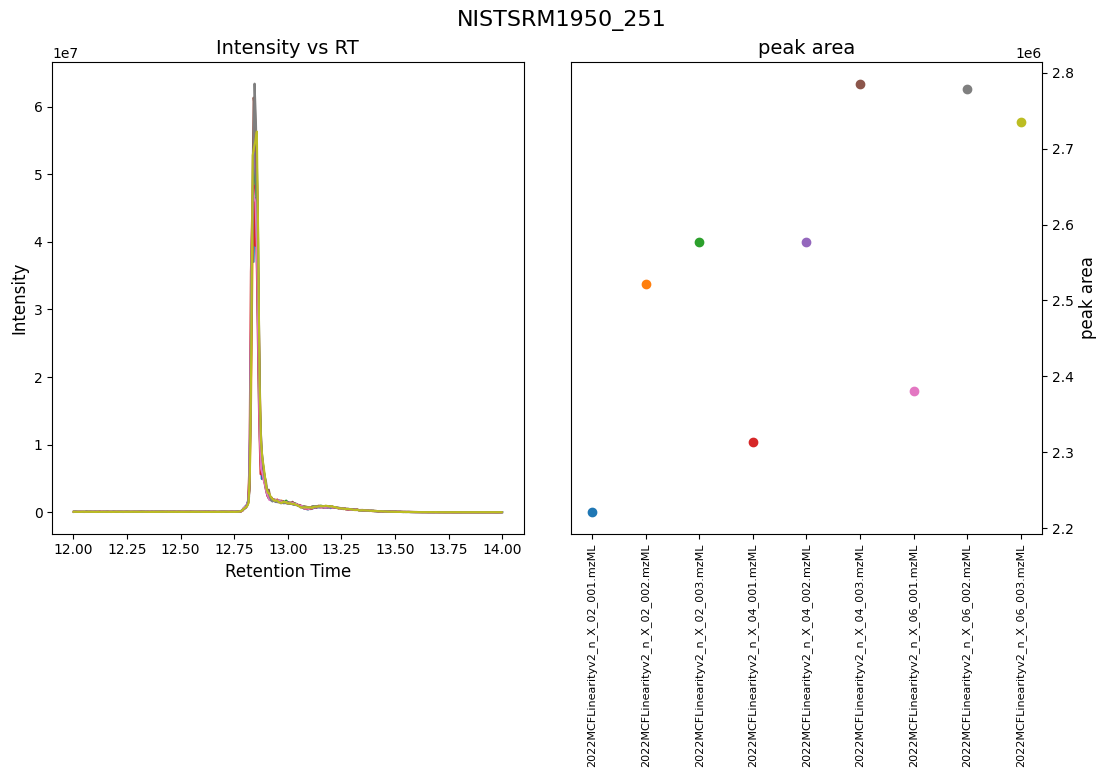

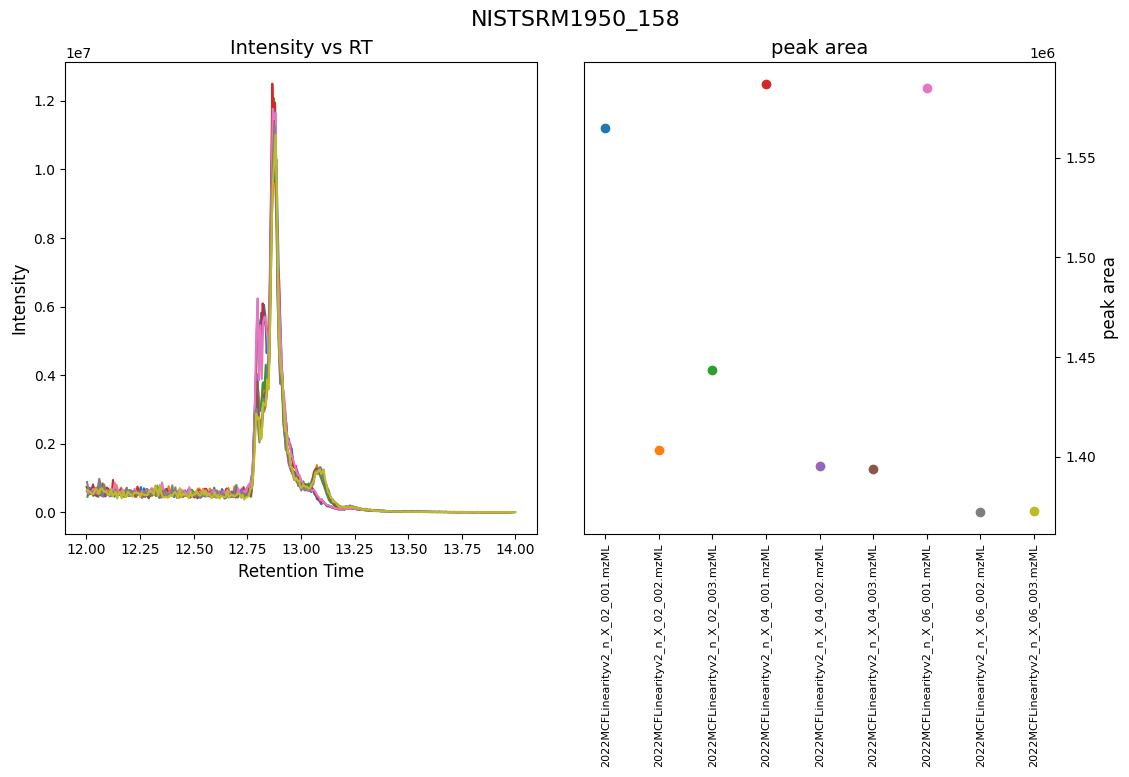

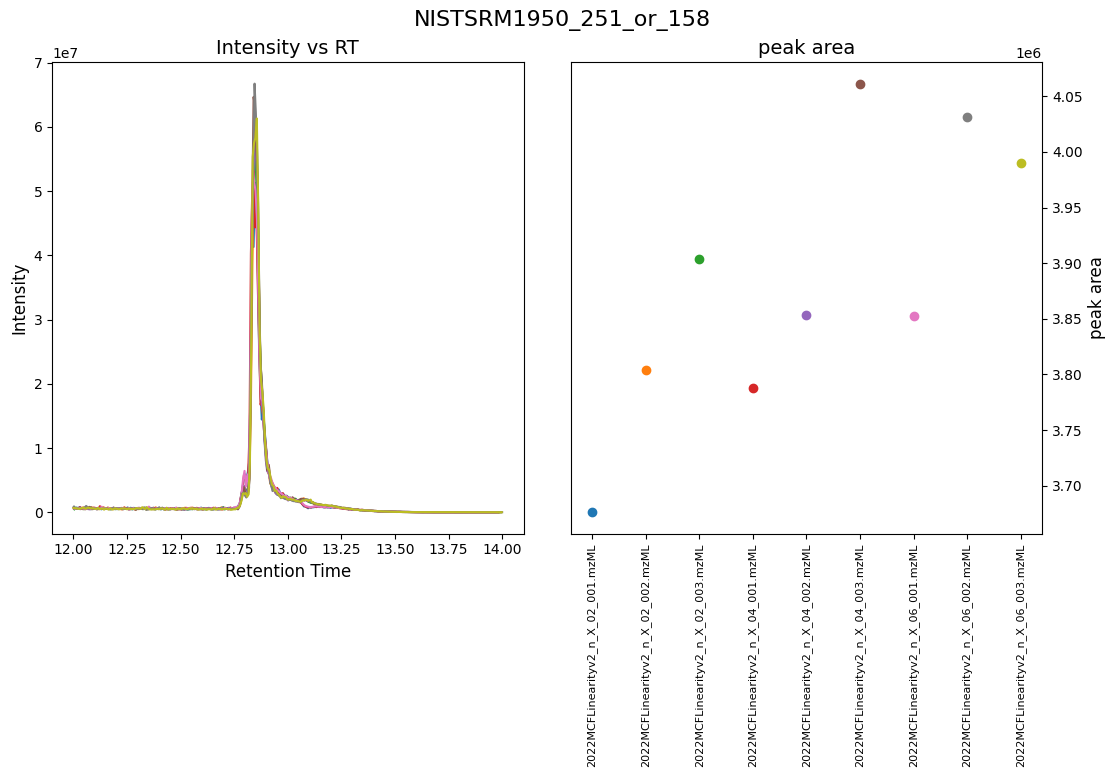

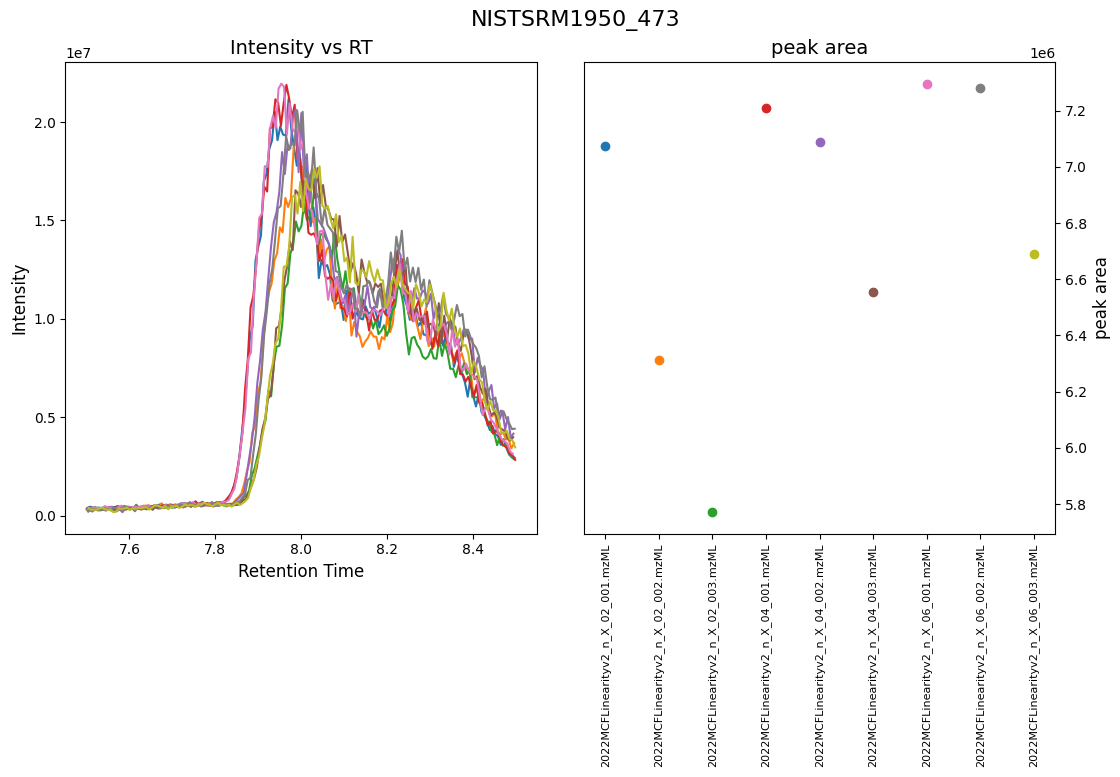

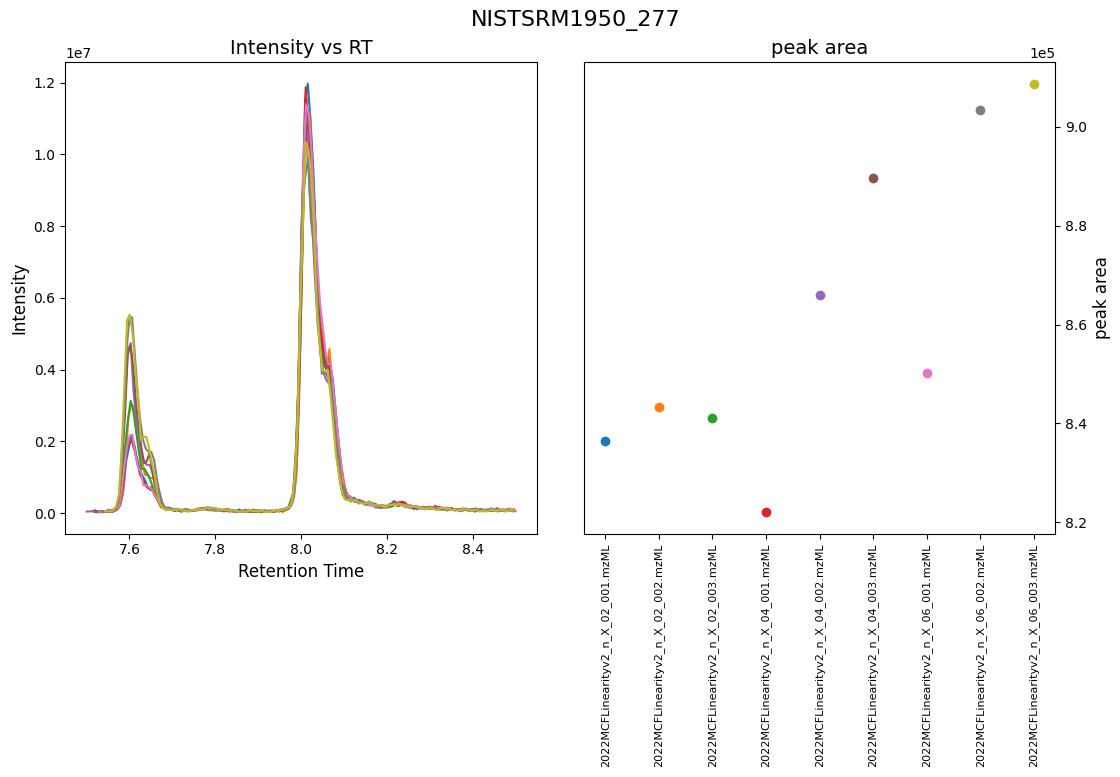

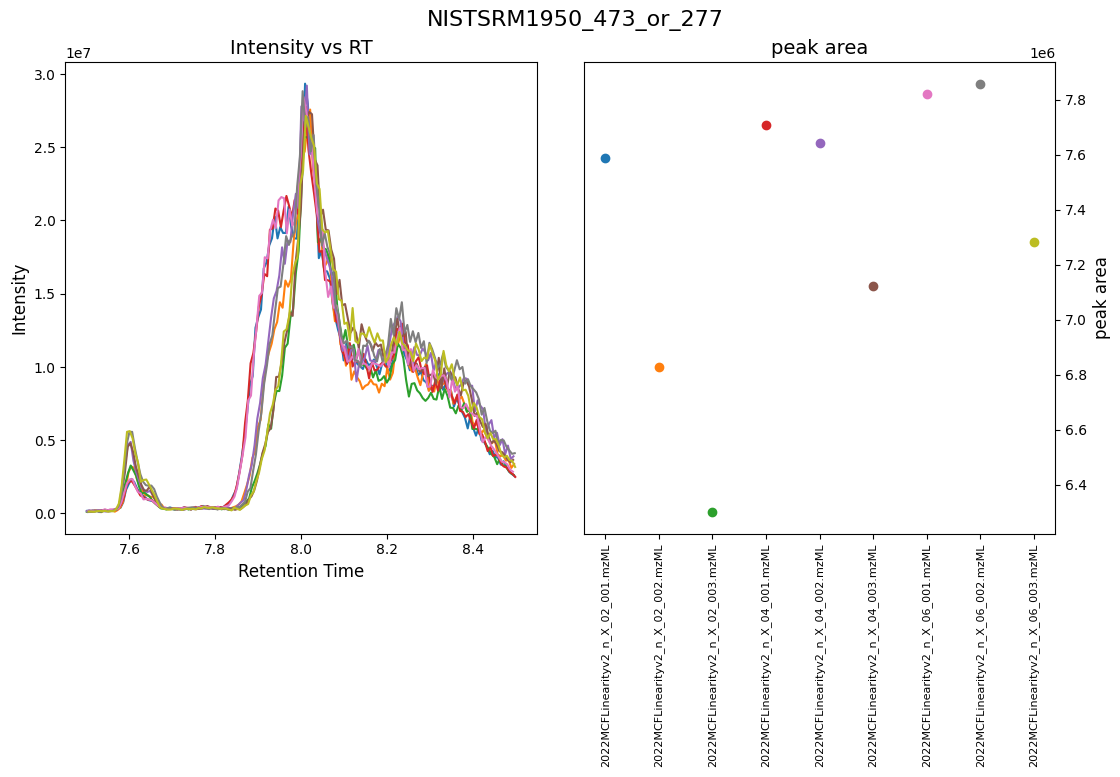

In [11]:
"""Integrate and Plot Results"""


for i, query in enumerate(queries):
    # int_range = float(query['rtmax']) - float(query['rtmin'])
    fig1 = plt.figure(figsize=(12,8))
    plt.subplots_adjust(bottom=0.3, top=.9, wspace = .1)
    fig1.suptitle(query['name'], y = .96, fontsize=16)
    fig1_sub1 = fig1.add_subplot(121, title='Intensity vs RT', xlabel='retention time', ylabel='intensity')
    fig1_sub1.title.set_size(14)
    # fig1_sub1.axvline(x=float(query['rtmin']), color='b')
    # fig1_sub1.axvline(x=float(query['rtmax']), color='b')
    # fig1_sub1.axvline(x=float(query['rtmin']), color='r', linestyle='--')
    # fig1_sub1.axvline(x=float(query['rtmax']), color='r', linestyle='--')
    # fig1_sub1.set_xlim([float(query['rtmin'])-(int_range/2), float(query['rtmax'])+(int_range/2)])
    fig1_sub1.set_ylabel('Intensity', fontsize=12)
    fig1_sub1.set_xlabel('Retention Time', fontsize=12)
    fig1_sub2 = fig1.add_subplot(122, title='peak area')
    # fig1_sub2.set_xlabel('file', fontsize=12)
    fig1_sub2.set_ylabel('peak area', fontsize=12)
    fig1_sub2.title.set_size(14)
    fig1_sub2.tick_params('x', labelrotation=90, labelsize=8)
    fig1_sub2.yaxis.tick_right()
    fig1_sub2.yaxis.set_label_position("right")
    fig1_sub2.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
    fig1_sub2.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))
    plt.subplots_adjust(bottom=0.3, top=.9, wspace = .1, left = 0.075)
    for file_n in results_df['file'].unique():
        file_directory, filename = file_n.rsplit('\\', 1)
        filename_noext = os.path.splitext(filename)[0]
        filtered_data = results_df.loc[(results_df['query_name']==query['name']) & (results_df['file']==file_n)].copy()
        peak_area = peak_area_df.loc[filename][query['name']]
        fig1_sub1.plot(filtered_data.rt, filtered_data.i)
        fig1_sub2.scatter(filename, peak_area)
    ratio = 1.0
    x_left, x_right = fig1_sub1.get_xlim()
    y_low, y_high = fig1_sub1.get_ylim()
    fig1_sub1.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
    x_left, x_right = fig1_sub2.get_xlim()
    y_low, y_high = fig1_sub2.get_ylim()
    fig1_sub2.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

"""Save Results to Files"""
timestr = time.strftime("%Y_%m_%d_%H%M")
def save_image(filename):
    p = PdfPages(filename)
    fig_nums = plt.get_fignums()
    figs = [plt.figure(n) for n in fig_nums]
    for fig in figs: 
        fig.savefig(p, format='pdf') 
    p.close()  

if not os.path.exists("SpectraSpectre_Output/"+timestr):
    os.makedirs("SpectraSpectre_Output/"+timestr)
pdf_filename = "SpectraSpectre_Output/"+timestr+"/"+timestr+"_images.pdf"  
save_image(pdf_filename)

# peak_area_df_new = peak_area_df.reset_index(names=['CORE_Filename'])
peak_area_df_new = peak_area_df.reset_index()
peak_area_df_new = peak_area_df_new.rename(columns = {'index':'CORE_Filename'})

raw_df.to_csv("SpectraSpectre_Output/"+timestr+"/"+timestr+"_raw_query_df.csv")  

# with pd.ExcelWriter("SpectraSpectre_Output/"+timestr+"/"+timestr+"_results.xlsx") as writer:
#     peak_area_df_new.to_excel(writer, sheet_name="results", index=False)
#     if not MassQL_query_df.empty:
#         MassQL_query_df.to_excel(writer, sheet_name="queries", index=False)
    
peak_area_df_transpose = peak_area_df_new.drop(columns=['file_directory'])

def remove_filename_ext(filenameext):
    # filenameext = str(filenameext)  # cast to string
    # filenamenoext = filenameext[:-5] # remove last five characters
    filenamenoext = os.path.splitext(str(filenameext))[0]
    return str(filenamenoext)

peak_area_df_transpose['CORE_Filename'] =peak_area_df_transpose['CORE_Filename'].apply(remove_filename_ext)
# peak_area_df_transpose['CORE_Filename'] = os.path.splitext(peak_area_df_transpose['CORE_Filename'])[0]

peak_area_df_transpose.set_index('CORE_Filename',inplace=True)
peak_area_df_transpose = peak_area_df_transpose.T
peak_area_df_transpose.to_csv("SpectraSpectre_Output/"+timestr+"/"+timestr+"_results.csv")  

print("\nResults saved to:")
print(os.getcwd()+"\\SpectraSpectre_Output\n")
# print('Complete\n')
# input("Press enter to exit...")

In [12]:
filename_groups_dict = {}
for key, value in filename_groups.items():
   if value in filename_groups_dict:
       filename_groups_dict[value].append(key)
   else:
       filename_groups_dict[value]=[key]

query_groups_dict = {}
for key, value in query_groups.items():
   if value in query_groups_dict:
       query_groups_dict[value].append(key)
   else:
       query_groups_dict[value]=[key]

In [13]:
analysis_df = peak_area_df_transpose.copy()
analysis_df_T = peak_area_df_transpose.copy().T

analysis_df_filename_grouped = pd.DataFrame()
analysis_df_query_grouped = pd.DataFrame()
analysis_df_both_grouped = pd.DataFrame()


for fname_group, fnames in filename_groups_dict.items():
    analysis_df_filename_grouped[fname_group] = analysis_df[fnames].sum(axis=1)

for qname_group, qnames in query_groups_dict.items():
    analysis_df_query_grouped[qname_group] = analysis_df_T[qnames].sum(axis=1)
analysis_df_query_grouped_T = analysis_df_query_grouped.T
analysis_df_query_grouped_T.columns.name = None

for fname_group, fnames in filename_groups_dict.items():
    analysis_df_both_grouped[fname_group] = analysis_df_query_grouped_T[fnames].sum(axis=1)


analysis_df_filename_grouped_log2 = np.log2(1+analysis_df_filename_grouped)
analysis_df_query_grouped_T_log2 = np.log2(1+analysis_df_query_grouped_T)
analysis_df_both_grouped_log2 = np.log2(1+analysis_df_both_grouped)

# display(analysis_df_filename_grouped)
# display(1+analysis_df_filename_grouped)

from  itertools import combinations

analysis_df_filename_grouped_ratio = {f'{a}/{b}': analysis_df_filename_grouped[a].div(analysis_df_filename_grouped[b]) for a, b in combinations(analysis_df_filename_grouped.columns, 2)}
if analysis_df_filename_grouped_ratio:
    analysis_df_filename_grouped_ratio = pd.concat(analysis_df_filename_grouped_ratio, axis=1)
    analysis_df_filename_grouped_ratio = analysis_df_filename_grouped_ratio.fillna("Null")
else:
    analysis_df_filename_grouped_ratio = pd.DataFrame()

analysis_df_query_grouped = analysis_df_query_grouped_T.T
analysis_df_query_grouped_ratio = {f'{a}/{b}': analysis_df_query_grouped[a].div(analysis_df_query_grouped[b]) for a, b in combinations(analysis_df_query_grouped.columns, 2)}
analysis_df_query_grouped_ratio = pd.concat(analysis_df_query_grouped_ratio, axis=1)
analysis_df_query_grouped_T_ratio = analysis_df_query_grouped_ratio.T
analysis_df_query_grouped_T_ratio = analysis_df_query_grouped_T_ratio.fillna("Null")

analysis_df_both_grouped_ratio = {f'{a}/{b}': analysis_df_both_grouped[a].div(analysis_df_both_grouped[b]) for a, b in combinations(analysis_df_both_grouped.columns, 2)}
if analysis_df_both_grouped_ratio:
    analysis_df_both_grouped_ratio = pd.concat(analysis_df_both_grouped_ratio, axis=1)
    analysis_df_both_grouped_ratio = analysis_df_both_grouped_ratio.fillna("Null")
else:
    analysis_df_both_grouped_ratio = pd.DataFrame()

with pd.ExcelWriter("SpectraSpectre_Output/"+timestr+"/"+timestr+"_analysis.xlsx") as writer:
    analysis_df_filename_grouped.to_excel(writer, sheet_name="filename_grouped", index=True)
    analysis_df_query_grouped_T.to_excel(writer, sheet_name="query_grouped", index=True)
    analysis_df_both_grouped.to_excel(writer, sheet_name="both_grouped", index=True)
    analysis_df_filename_grouped_ratio.to_excel(writer, sheet_name="filename_grouped_ratio", index=True)
    analysis_df_query_grouped_T_ratio.to_excel(writer, sheet_name="query_grouped_ratio", index=True)
    analysis_df_both_grouped_ratio.to_excel(writer, sheet_name="both_grouped_ratio", index=True)

    
analysis_df_filename_grouped_log2_ratio = {f'{a}_{b}': analysis_df_filename_grouped_log2[a].sub(analysis_df_filename_grouped_log2[b]) for a, b in combinations(analysis_df_filename_grouped_log2.columns, 2)}
if analysis_df_filename_grouped_log2_ratio:
    analysis_df_filename_grouped_log2_ratio = pd.concat(analysis_df_filename_grouped_log2_ratio, axis=1)
    analysis_df_filename_grouped_log2_ratio = analysis_df_filename_grouped_log2_ratio.fillna("Null")
else:
    analysis_df_filename_grouped_log2_ratio = pd.DataFrame()

analysis_df_query_grouped_log2 = analysis_df_query_grouped_T_log2.T
analysis_df_query_grouped_log2_ratio = {f'{a}_{b}': analysis_df_query_grouped_log2[a].sub(analysis_df_query_grouped_log2[b]) for a, b in combinations(analysis_df_query_grouped_log2.columns, 2)}
analysis_df_query_grouped_log2_ratio = pd.concat(analysis_df_query_grouped_log2_ratio, axis=1)
analysis_df_query_grouped_T_log2_ratio = analysis_df_query_grouped_log2_ratio.T
analysis_df_query_grouped_T_log2_ratio = analysis_df_query_grouped_T_log2_ratio.fillna("Null")

analysis_df_both_grouped_log2_ratio = {f'{a}_{b}': analysis_df_both_grouped_log2[a].sub(analysis_df_both_grouped_log2[b]) for a, b in combinations(analysis_df_both_grouped_log2.columns, 2)}
if analysis_df_both_grouped_log2_ratio:
    analysis_df_both_grouped_log2_ratio = pd.concat(analysis_df_both_grouped_log2_ratio, axis=1)
    analysis_df_both_grouped_log2_ratio = analysis_df_both_grouped_log2_ratio.fillna("Null")
else:
    analysis_df_both_grouped_log2_ratio = pd.DataFrame()

# analysis_df_filename_grouped_log2 = np.log2(analysis_df_filename_grouped)
# analysis_df_query_grouped_T_log2 = np.log2(analysis_df_query_grouped_T)
# analysis_df_both_grouped_log2 = np.log2(analysis_df_both_grouped)

with pd.ExcelWriter("SpectraSpectre_Output/"+timestr+"/"+timestr+"_analysis_log2.xlsx") as writer:
    analysis_df_filename_grouped_log2.to_excel(writer, sheet_name="filename_grouped", index=True)
    analysis_df_query_grouped_T_log2.to_excel(writer, sheet_name="query_grouped", index=True)
    analysis_df_both_grouped_log2.to_excel(writer, sheet_name="both_grouped", index=True)
    analysis_df_filename_grouped_log2_ratio.to_excel(writer, sheet_name="filename_grouped_ratio", index=True)
    analysis_df_query_grouped_T_log2_ratio.to_excel(writer, sheet_name="query_grouped_ratio", index=True)
    analysis_df_both_grouped_log2_ratio.to_excel(writer, sheet_name="both_grouped_ratio", index=True)


In [14]:
"""System Suitability"""

QC_df = peak_area_df_new[peak_area_df_new['CORE_Filename'].str.startswith(tuple(QC_files)) | peak_area_df_new['CORE_Filename'].str.startswith('QC_')]
# QC_df = peak_area_df_new[peak_area_df_new['CORE_Filename'].str.startswith('QC_')]
if QC_df.empty:
    print("No System Suitability Check\n")
elif not MassQL_query_df:
    print("No System Suitability Check\n")
else:
    peak_area_df_QC1 = peak_area_df_new.copy()
    qc_dict = {'CORE_Filename': 'QC_Average'}

    for index, row in MassQL_query_df.iterrows():
        qname = row['Name']
        qave = QC_df.loc[:, qname].mean()
        qc_dict.update({qname:qave})

    qc_row = pd.Series(qc_dict)
    peak_area_df_QC1 = pd.concat([peak_area_df_QC1, qc_row.to_frame().T], ignore_index=True)
    peak_area_df_QC1 = peak_area_df_QC1.set_index('CORE_Filename')
    peak_area_df_QC1 = peak_area_df_QC1.drop('file_directory', axis=1)
    peak_area_df_QC2 = peak_area_df_QC1.copy()

    peak_area_df_QC2.loc["2022MCF0031_p_QCcurve_02_02.mzML","propionyl carnitine-d3"] = 1001

    for index, row in MassQL_query_df.iterrows():
        qname = row['Name']
        qthreshold = row['QC_threshold']
        qave = QC_df.loc[:, qname].mean()
        peak_area_df_QC2[qname] = peak_area_df_QC2[qname].apply(lambda x: 1 if qave==x else (None if qave == 0 else x/qave))

    peak_area_df_QC3 = peak_area_df_QC2.copy()

    for index, row in MassQL_query_df.iterrows():
        qname = row['Name']
        qthreshold = row['QC_threshold']
        peak_area_df_QC3[qname] = peak_area_df_QC3[qname].apply(lambda x: True if math.isclose(1,x,abs_tol=qthreshold) else False)

    peak_area_df_QC = peak_area_df_QC3.copy()
    peak_area_df_QC['System_Suitability'] = peak_area_df_QC.all(axis=1)
    # peak_area_df_QC = peak_area_df_QC[~peak_area_df_QC.index.str.startswith('QC_')]
    peak_area_df_QC = peak_area_df_QC[~(peak_area_df_QC.index.str.startswith(tuple(QC_files)) | peak_area_df_QC.index.str.startswith('QC_'))]
    peak_area_df_QC = peak_area_df_QC.loc[:, peak_area_df_QC.columns.str.startswith('System_Suitability')]

    peak_area_df_QC = peak_area_df_QC.reset_index()
    peak_area_df_QC1 = peak_area_df_QC1.reset_index()
    peak_area_df_QC2 = peak_area_df_QC2.reset_index()
    peak_area_df_QC3 = peak_area_df_QC3.reset_index()

    with pd.ExcelWriter("SpectraSpectre_Output/"+timestr+"/"+timestr+"_QC.xlsx") as writer:
        peak_area_df_QC.to_excel(writer, sheet_name="QC", index=False)
        peak_area_df_QC1.to_excel(writer, sheet_name="QC1", index=False)
        peak_area_df_QC2.to_excel(writer, sheet_name="QC2", index=False)
        peak_area_df_QC3.to_excel(writer, sheet_name="QC3", index=False)

    print('System Suitability Results:\n')
    # print(QC_df['CORE_Filename'].values.tolist())
    print('QC Files: ' + str(QC_df['CORE_Filename'].values.tolist()))
    print('\n')
    print(peak_area_df_QC)
    print('\n')


No System Suitability Check



In [20]:
if kegg_path and not analysis_df_filename_grouped_log2_ratio.empty:
    print("\nCreating KEGG Maps\n")
    # os.chdir(starting_directory)
          
    import Bio
    Bio.__version__
    import ssl
    ssl._create_default_https_context = ssl._create_unverified_context

    from Bio import SeqIO
    from Bio.KEGG.REST import *
    from Bio.KEGG.KGML import KGML_parser
    from Bio.Graphics.KGML_vis import KGMLCanvas
    from Bio.Graphics.ColorSpiral import ColorSpiral
    from IPython.display import Image, HTML
    import random
    from pdf2image import convert_from_path
    from IPython.display import Image 

    # A bit of code that will help us display the PDF output
    def PDF(filename):
        return HTML('<iframe src=%s width=700 height=350></iframe>' % filename)

    # A bit of helper code to shorten long text
    def head(text, lines=10):
        """ Print the first lines lines of the passed text."""
        print('\n'.join(text.split('\n')[:lines] + ['[...]']))

    def rgb_to_hex(rgb):
        rgb = tuple([int(val) for val in rgb])
        return '#' + ''.join([hex(val)[2:] for val in rgb]).upper()

    
    # peak_area_df_transform = peak_area_df_new.copy()
    
    peak_area_df_transform = analysis_df_filename_grouped_log2_ratio.T.copy()
    # def transform_func(number):
    #     return np.log2(1+number)

    # executing the function
    bad_column = ["CORE_Filename", "file_directory"]
    other_cols = peak_area_df_transform.columns.difference(bad_column)
    # peak_area_df_transform[other_cols] = peak_area_df_transform[other_cols].apply(transform_func)
    # display(peak_area_df_transform)
    # peak_area_df_transform[other_cols]= peak_area_df_transform[other_cols].div(peak_area_df_transform[other_cols].iloc[0])
    # display(peak_area_df_transform)

    # displaying the DataFrame
    # display(peak_area_df_transform)
    

    for index, row in peak_area_df_transform[other_cols].iterrows():
        shade_dict = {}
        if index == 0:
            pass
        else:
            for col_name in peak_area_df_transform[other_cols].columns:
                # print(f"{col_name}: {row[col_name]}")
                if col_name in name_kegg_dict.keys():
                    cid = str(name_kegg_dict[col_name])
                    cid = cid.replace(u'\xa0', u'')
                    
                    if row[col_name] > 0:
                        if row[col_name] >= 1:
                            mer = '#%02x%02x%02x' % (0, 0, 255)
                        else:
                            color_val = int(255*(1-row[col_name]))
                            mer = '#%02x%02x%02x' % (color_val, color_val, 255)
                    elif row[col_name] < 0:
                        if row[col_name] <= -1:
                            mer = '#%02x%02x%02x' % (255, 0, 0)
                        else:
                            color_val = int(255*(1+row[col_name]))
                            mer = '#%02x%02x%02x' % (255, color_val, color_val)
                    elif row[col_name] == 0:
                        mer = rgb_to_hex([255,255,255])
                    else:
                        mer = rgb_to_hex([155,155,155])

                    shade_dict.update({str(cid):mer})

                    # from reportlab.lib.colors import HexColor
        try:
            kegg_path = "hsa00020"
            pathway = KGML_parser.read(kegg_get(kegg_path, "kgml"))
            for x in pathway.compounds:
                # print(str(shade_dict[x.graphics[0].name]))
                # print(shade_dict)
                try:
                    x.graphics[0].bgcolor = str(shade_dict[x.graphics[0].name]) + str('CC')
                    # x.graphics[0].bgcolor = str(shade_dict[x.graphics[0].name])

                    # x.graphics[0].fgcolor = str(shade_dict[x.graphics[0].name])
                    if shade_dict[x.graphics[0].name] == '#FFFFFF' or shade_dict[x.graphics[0].name] == "#969696":   
                        x.graphics[0].fgcolor = "#000000" + str('66')
                    else:
                        x.graphics[0].fgcolor = str(shade_dict[x.graphics[0].name]) + str('CC')
                except Exception:
                    pass
                    # print('no match')
                x.graphics[0].type="circle"
                # x.graphics[0].fgcolor = "#d1d1d1"
                x.graphics[0].width = 30
                x.graphics[0].height = 17
    
            for x in pathway.orthologs:
                x.graphics[0].fgcolor = "#b3b3b3"
                x.graphics[0].bgcolor = "#ffffff"
                # x.graphics[0].width = 40
                # x.graphics[0].height = 40
    
            for x in pathway.genes:
                x.graphics[0].fgcolor = "#b3b3b3"
                x.graphics[0].bgcolor = "#ffffff"
                # x.graphics[0].width = 40
                # x.graphics[0].height = 40
    
            canvas = KGMLCanvas(pathway, import_imagemap=True)
            kegg_pdf_path = "SpectraSpectre_Output/"+timestr+"/"+timestr+"_kegg_map_"+kegg_path+"_"+str(index)+".pdf"
            # print(shade_dict)

            canvas.draw(kegg_pdf_path)
            print(index + " created")

        #     # PDF("fab_map_with_image.pdf")
    
        #     # Store Pdf with convert_from_path function
        #     poppler = False
        #     # if poppler:
        #     #     images = convert_from_path(kegg_pdf_path, poppler_path = r"C:\ProgramFilesFolder\poppler-23.07.0\Library\bin")
        #     #     for i in range(len(images)):
        #     #         images[i].save('page'+ str(i) +'.jpg', 'JPEG')
        #     #     Image("SpectraSpectre_Output/"+timestr+"/"+timestr+"_kegg_map_"+kegg_path+".jpg")
        #     # print("Created KEGG map")
        except Exception:
            print("Problem Creating KEGG map \n\n Try Enabling VPN if NOT active \n")


Creating KEGG Maps

wt_other created
wt_mutant created
other_mutant created


In [ ]:
print('Complete\n')
input("Press enter to exit...")